<a href="https://colab.research.google.com/github/gandhimonil9823/Covid_Stock_Analysis/blob/main/Covid_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [28]:
!pip install -q pyproj==1.9.6

In [29]:
!pip install pathpy

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import statistics 
import numpy as np
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import pathpy as pp
from geopy import distance
from geopy.distance import geodesic
import itertools
import math

In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [33]:
# Merging the Stock Indexes and the currency data with rows as dates and columns as index values
# Preprocessing the data sets with online steps for data processing 
# Figuring a way to convert the unemployment data into county wise data - probably using a probability distribution
# Deal with missing stock data for weekends and holidays

Stock Data: Pre-processing


In [47]:
# Reading CSVs for three stock indices
df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/DJI.csv")
df_DJI = df[["Date", "Adj Close", "Volume"]]

df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/NASDAQ.csv")
df_NASDAQ = df[["Date", "Adj Close", "Volume"]]

df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/S&P500.csv")
df_SP500 = df[["Date", "Adj Close", "Volume"]]

df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")

trend_seasonality_df = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/trend_seasonality_covid.csv")


df_centroid = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/pre_processed_centroid.csv")

df_with_missing = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/stock_closing_prices_188.csv")
df_with_missing_historical = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/stock_data/historical_data_filled_188.csv")

In [ ]:
# Rename columns in each index in order to merge the indices 
df_NASDAQ = df_NASDAQ.rename(columns={'Adj Close': 'Adj_Close_NASDAQ', 'Volume': 'Volume_NASDAQ'})
df_SP500 = df_SP500.rename(columns={'Adj Close': 'Adj_Close_SP500', 'Volume': 'Volume_SP500'})
df_DJI = df_DJI.rename(columns={'Adj Close': 'Adj_Close_DJI', 'Volume': 'Volume_DJI'})

In [ ]:
# Merging data of three stock indices based on column: 'Date' (merging two DFs at once)
df_Merged = pd.merge(df_SP500, df_DJI, on=['Date'])
df_stock_data = pd.merge(df_Merged, df_NASDAQ, on=['Date'])

In [ ]:
df_stock_data.head()

Date  Adj_Close_SP500  ...  Adj_Close_NASDAQ  Volume_NASDAQ
0  2015-10-26      2071.179932  ...       5034.700195     1758690000
1  2015-10-27      2065.889893  ...       5030.149902     1986840000
2  2015-10-28      2090.350098  ...       5095.689941     2141130000
3  2015-10-29      2089.409912  ...       5074.270020     1928310000
4  2015-10-30      2079.360107  ...       5053.750000     2016390000

[5 rows x 7 columns]

In [ ]:
df_stock_data.shape

(1259, 7)

In [ ]:
df_with_missing.head()

Date  Adj_Close_SP500  Adj_Close_DJI  Adj_Close_NASDAQ
0  2020-01-22      3321.750000    29186.26953       9383.769531
1  2020-01-23      3325.540039    29160.08984       9402.480469
2  2020-01-24      3295.469971    28989.73047       9314.910156
3  2020-01-25      3278.098532    28837.62388       9256.004910
4  2020-01-26      3260.818664    28686.31538       9197.472167

In [ ]:
df_with_missing.shape

(188, 4)

In [ ]:
df_with_missing_historical

Date  Adj_Close_SP500  Adj_Close_DJI  Adj_Close_NASDAQ
0    2019-07-18      2995.110107    27222.97070       8207.240234
1    2019-07-19      2976.610107    27154.19922       8146.490234
2    2019-07-20      2979.414105    27160.09833       8165.661554
3    2019-07-21      2982.220745    27165.99872       8184.877990
4    2019-07-22      2985.030029    27171.90039       8204.139648
..          ...              ...            ...               ...
183  2020-01-17      3329.620117    29348.09961       9388.940430
184  2020-01-18      3326.674152    29297.32497       9382.892916
185  2020-01-19      3323.730793    29246.63817       9376.849296
186  2020-01-20      3325.202147    29271.97060       9379.870619
187  2020-01-21      3320.790039    29196.03906       9370.809570

[188 rows x 4 columns]

# COVID-19 Data Loading and Preprocessing

In [ ]:
# Function to load the covid_clean_complete dataset from the drive
def load_dataset_us_cases():  
  df_covid_clean_complete = pd.read_csv("/content/drive/Shared drives/Stock_Covid_Data/COVID_19/covid_19_clean_complete.csv")
  return df_covid_clean_complete

# Function to preprocess the clean_complete_dataset
def preprocess_us_cases_df():
  df_US_daily_cases = load_dataset_us_cases()

  # get the daily data only for US
  df_US_daily_cases = df_covid_clean_complete.loc[df_covid_clean_complete['Country/Region'] == "US"]
  
  df_US_daily_cases = df_US_daily_cases.reset_index(drop=True)

  # Added a column for new_cases daily by getting the differerence of the confirmed cases
  df_US_daily_cases["New_cases"] = df_US_daily_cases["Confirmed"].diff()
  
  df_US_daily_cases['New_cases'] = df_US_daily_cases['New_cases'].fillna(0)

  df_US_daily_cases = df_US_daily_cases.rename(columns={"Confirmed": "Total_Confirmed", "Deaths" : "Total_Deaths"})

  return df_US_daily_cases


# Standardize the COVID variables like New_cases, Total_cases, Total_deaths

In [ ]:
# Function to standardize the covid_variables like New_cases, Total_cases, Total_deaths
# Adds new columns to the df with the standarized values
# params - the dataframe, and the column name (COVID Variable) which has to be standarized
def covid_variable_impact_cal(dataframe_to_standardize, column_name):
  # col_mean = dataframe_to_standardize[column_name].mean()
  # col_std  = dataframe_to_standardize[column_name].std()

  col_name = "Standardized_Value_" + column_name
  dataframe_to_standardize[col_name] = dataframe_to_standardize[column_name]

  i = 0
  j = 0
  while i < len(dataframe_to_standardize):
    j = i
    if i > 7:
      col_mean = dataframe_to_standardize[column_name][j - 8: j - 1].mean()
      col_std  = statistics.stdev(dataframe_to_standardize[column_name][j - 8: j - 1])

      curr_daily_value = dataframe_to_standardize[column_name][i]

      formula_cal_value = (curr_daily_value - col_mean) / col_std

      dataframe_to_standardize.loc[i, col_name] = formula_cal_value

    i += 1
  dataframe_to_standardize[col_name].replace(np.inf, 0, inplace=True)
  return dataframe_to_standardize

In [ ]:
df_US_daily_cases = preprocess_us_cases_df()
df_US_daily_cases.head()



Province/State Country/Region   Lat  ...  Active WHO Region  New_cases
0            NaN             US  40.0  ...       1   Americas        0.0
1            NaN             US  40.0  ...       1   Americas        0.0
2            NaN             US  40.0  ...       2   Americas        1.0
3            NaN             US  40.0  ...       2   Americas        0.0
4            NaN             US  40.0  ...       5   Americas        3.0

[5 rows x 11 columns]

In [ ]:
df_standarized_total_confirmed = covid_variable_impact_cal(df_US_daily_cases, "Total_Confirmed")

df_standarized_total_confirmed.reset_index().plot(x='index', y='Standardized_Value_Total_Confirmed')    

df_standarized_Total_Deaths = covid_variable_impact_cal(df_US_daily_cases, "Total_Deaths")

df_standarized_Total_Deaths.reset_index().plot(x='index', y='Standardized_Value_Total_Deaths')

df_standarized_New_cases = covid_variable_impact_cal(df_US_daily_cases, "New_cases")

df_standarized_New_cases.reset_index().plot(x='index', y='Standardized_Value_New_cases')

# Complex Network Analysis

In [ ]:
# Using Centroid of all the long and lat
# def combinations_distance_df(df_original):
#     counties  = df_original["Combined_Key"]
    
#     list_of_counties_combinations = list(itertools.combinations(counties,2))

#     df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

#     array_distances = []
#     for item in list_of_counties_combinations:
#         row_element1 = df_original.loc[df_original['Combined_Key'] == item[0]]
#         row_element2 = df_original.loc[df_original['Combined_Key'] == item[1]]
        
#         value1 = float(row_element1["Centroid_Distance"].tolist()[0])
#         value2 = float(row_element2["Centroid_Distance"].tolist()[0])

#         array_distances.append(abs(value1 - value2))

#     df_to_return["Distance"] = array_distances
#     return df_to_return    


# Using Two counties difference directly
def combinations_distance_df(df_original):
    counties  = df_original["Combined_Key"]

    list_of_counties_combinations = list(itertools.combinations(counties,2))

    df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

    array_distances = []
    for item in list_of_counties_combinations:
        row_element1 = df_original.loc[df_original['Combined_Key'] == item[0]]
        row_element2 = df_original.loc[df_original['Combined_Key'] == item[1]]

        long1 = float(row_element1["Long_"].tolist()[0])
        lat1 = float(row_element1["Lat"].tolist()[0])
        
        long2 = float(row_element2["Long_"].tolist()[0])
        lat2 = float(row_element2["Lat"].tolist()[0])

        point_n = geodesic((lat1, long1),(lat2, long2)).miles
        
        array_distances.append(point_n)

    df_to_return["Distance"] = array_distances
    return df_to_return    

    

In [ ]:
df_centroid = df_centroid[df_centroid.New_cases != 0]

df_centroid = df_centroid.reset_index(drop=True)

groupby_daily = df_centroid.groupby(df_centroid["Date"])

i = 0
g = None
for name, group in groupby_daily:
# 2174
    if len(group) == 2174:
        fig = plt.figure(figsize=(16, 10))
        m_ = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        m_.readshapefile('/content/drive/Shared drives/Stock_Covid_Data/COVID_19/st99_d00', name='states')
        df_comb_counties_distance = combinations_distance_df(group)
        G_t = pp.Network(directed=False)
        for index_group, row_group in group.iterrows():
            if row_group["New_cases"] >= 0:
                G_t.add_node(str(row_group["Combined_Key"]))
        m_.scatter(group["Long_"].tolist(), group["Lat"].tolist(), latlon=True, s=25, c="red", marker='o')    
        for index, row in df_comb_counties_distance.iterrows():
            if row["Distance"] < 100:
                tuple_county = row["Combinations"]
                if str(tuple_county[0]) in G_t.nodes and str(tuple_county[1]) in G_t.nodes:
                    G_t.add_edge(str(tuple_county[0]), str(tuple_county[1]))
        plt.title(str(name), fontsize=20)
        
        g = G_t
#         print(name)


#         pp.visualisation.plot(G_t)    
    # print(len(group))
        
style = {'width': 1000, 
          'height': 1000
        }
pp.visualisation.export_html(g, 'my_temporal_network.html')
pp.visualisation.plot(g,**style)

# Complex Network Analysis for Trend and Seasonality


In [48]:
trend_seasonality_df = trend_seasonality_df[trend_seasonality_df["Date"] == "2020-7-27"]

print(trend_seasonality_df["Trend"].min())
print(trend_seasonality_df["Trend"].max())

print(trend_seasonality_df["Seasonal"].min())
print(trend_seasonality_df["Seasonal"].max())


-23.057685082190066
3581.666499814608
-232.59964676310943
65.36593260000824


In [59]:
trend_seasonality_df['bin'] = pd.qcut(trend_seasonality_df['Trend'], q=10)

# print(trend_seasonality_df)

groupby_bin = trend_seasonality_df.groupby(trend_seasonality_df["bin"])

for name, group in groupby_bin:
  print(name)

# array = trend_seasonality_df["bin"].unique()

# array[0]




(-23.059, 0.123]
(0.123, 0.43]
(0.43, 0.888]
(0.888, 1.584]
(1.584, 2.614]
(2.614, 4.538]
(4.538, 7.546]
(7.546, 14.118]
(14.118, 36.554]
(36.554, 3581.666]


In [60]:
def combinations_bin_counties(df_original):
    counties  = df_original["Combined_Key"]

    list_of_counties_combinations = list(itertools.combinations(counties,2))

    df_to_return = pd.DataFrame({"Combinations" : list_of_counties_combinations})

    return df_to_return

In [65]:
# trend_seasonality_df = trend_seasonality_df[trend_seasonality_df.Trend != 0]

# trend_seasonality_df = trend_seasonality_df.reset_index(drop=True)

groupby_daily = trend_seasonality_df.groupby(trend_seasonality_df["Date"])
g = None
for name, group in groupby_daily:
  if name == "2020-7-27" :
    group['bin'] = pd.qcut(group['Trend'], q=10)
    groupby_bin = trend_seasonality_df.groupby(trend_seasonality_df["bin"])
    for name_bin, group_bin in groupby_bin:
      print(name_bin)
      df_comb_counties_bin = combinations_bin_counties(group_bin)
      G_t = pp.Network(directed=False)
      for index_group, row_group in group_bin.iterrows():
        if row_group["New_cases"] >= 5:
          G_t.add_node(str(row_group["Combined_Key"]))
      for index_bin, row_bin in df_comb_counties_bin.iterrows():
        tuple_county = row_bin["Combinations"]
        if str(tuple_county[0]) in G_t.nodes and str(tuple_county[1]) in G_t.nodes:
          G_t.add_edge(str(tuple_county[0]), str(tuple_county[1]))
          
          
    g = G_t
      
style = {'width': 1000, 
          'height': 1000
        }
pp.visualisation.export_html(g, 'my_temporal_network.html')
pp.visualisation.plot(g,**style)

(-23.059, 0.123]
(0.123, 0.43]
(0.43, 0.888]
(0.888, 1.584]
(1.584, 2.614]
(2.614, 4.538]
(4.538, 7.546]
(7.546, 14.118]
(14.118, 36.554]
(36.554, 3581.666]


## Computing Stock paramaters - Abnormal price and Volatality:

In [ ]:
def compute_stock_params(covid_stock_values, precovid_stock_values):
  
  # Average of daily stock prices in the pre-COVID period (P_t-i)
  precovid_stocks_sum = precovid_stock_values[1::].sum()
  avg_precovid_stocks = precovid_stocks_sum[1::].div(188)

  # Differece between the daily stock prices in the COVID period and the average of daily stock prices in the pre-covid period (P_t - P_t-i)
  snp_diff = [daily_stocks - avg_precovid_stocks[0] for daily_stocks in precovid_stock_values['Adj_Close_SP500']]
  dji_diff = [daily_stocks - avg_precovid_stocks[1] for daily_stocks in precovid_stock_values['Adj_Close_DJI']]
  nasdaq_diff = [daily_stocks - avg_precovid_stocks[2] for daily_stocks in precovid_stock_values['Adj_Close_NASDAQ']]

  diff = pd.DataFrame(
    {'Adj_Close_SP500': snp_diff,
     'Adj_Close_DJI': dji_diff,
     'Adj_Close_NASDAQ': nasdaq_diff
    })
  
  # Standard deviatoon of the pre-COVID period
  sd_stock_indices = (diff**2 / 188)**0.5

  # Abnormal price  
  abnormal_price = (covid_stock_values -  avg_precovid_stocks) / sd_stock_indices;
  abnormal_price['Date'] = covid_stock_values['Date']

  print("covid_stock_values = ",covid_stock_values)
  # log(P_t/P_t-1)
  rt = pd.DataFrame([[0, 0, 0]], columns = ['Adj_Close_SP500', 'Adj_Close_DJI', 'Adj_Close_NASDAQ'])
  for i in range(1, len(covid_stock_values)):
    previous = covid_stock_values.loc[i-1,covid_stock_values.columns != 'Date']
    today = covid_stock_values.loc[i,covid_stock_values.columns != 'Date']
    temp = today.div(previous)
    rt = rt.append(temp, ignore_index=True)

  rt = rt.apply(np.log10)
  
  # Volatality of closing stock prices in the COVID period
  vol = rt**2

  rt['Date'] = covid_stock_values['Date']
  vol['Date'] = covid_stock_values['Date']
  
  return abnormal_price, rt, vol

In [ ]:
abnormal_price, rt, vol = compute_stock_params(df_with_missing, df_with_missing_historical)
abnormal_price

covid_stock_values =             Date  Adj_Close_SP500  Adj_Close_DJI  Adj_Close_NASDAQ
0    2020-01-22      3321.750000    29186.26953       9383.769531
1    2020-01-23      3325.540039    29160.08984       9402.480469
2    2020-01-24      3295.469971    28989.73047       9314.910156
3    2020-01-25      3278.098532    28837.62388       9256.004910
4    2020-01-26      3260.818664    28686.31538       9197.472167
..          ...              ...            ...               ...
183  2020-07-23      3235.659912    26652.33008      10461.419920
184  2020-07-24      3215.629883    26469.89063      10363.179690
185  2020-07-25      3223.537100    26508.12833      10420.558030
186  2020-07-26      3231.463760    26546.42127      10478.254050
187  2020-07-27      3239.409912    26584.76953      10536.269530

[188 rows x 4 columns]


Adj_Close_DJI Adj_Close_NASDAQ Adj_Close_SP500        Date
0         905.153           113.33         90.0023  2020-01-22
1         699.294          78.0225         63.8512  2020-01-23
2         754.057          79.7732         59.8895  2020-01-24
3         842.337          84.6297         58.6394  2020-01-25
4          981.11          90.9915          57.284  2020-01-26
..            ...              ...             ...         ...
183      -3.43808          27.6535         9.28907  2020-07-23
184      -4.70963          26.5285         8.43162  2020-07-24
185      -4.57059          27.4368          8.8984  2020-07-25
186      -4.26238          28.1141         9.23158  2020-07-26
187      -4.16147          29.1272         9.76143  2020-07-27

[188 rows x 4 columns]

In [ ]:
rt

Adj_Close_SP500  Adj_Close_DJI  Adj_Close_NASDAQ        Date
0               -inf           -inf              -inf  2020-01-22
1           0.000495      -0.000390          0.000865  2020-01-23
2          -0.003945      -0.002545         -0.004064  2020-01-24
3          -0.002295      -0.002285         -0.002755  2020-01-25
4          -0.002295      -0.002285         -0.002755  2020-01-26
..               ...            ...               ...         ...
183        -0.005384      -0.005723         -0.010042  2020-07-23
184        -0.002697      -0.002983         -0.004098  2020-07-24
185         0.001067       0.000627          0.002398  2020-07-25
186         0.001067       0.000627          0.002398  2020-07-26
187         0.001067       0.000627          0.002398  2020-07-27

[188 rows x 4 columns]

In [ ]:
vol

Adj_Close_SP500  Adj_Close_DJI  Adj_Close_NASDAQ        Date
0                inf            inf               inf  2020-01-22
1       2.452600e-07   1.518903e-07      7.484104e-07  2020-01-23
2       1.556162e-05   6.475397e-06      1.651422e-05  2020-01-24
3       5.268656e-06   5.219874e-06      7.590543e-06  2020-01-25
4       5.268655e-06   5.219874e-06      7.590543e-06  2020-01-26
..               ...            ...               ...         ...
183     2.898400e-05   3.274706e-05      1.008392e-04  2020-07-23
184     7.272797e-06   8.898506e-06      1.679038e-05  2020-07-24
185     1.137672e-06   3.930256e-07      5.750154e-06  2020-07-25
186     1.137672e-06   3.930257e-07      5.750152e-06  2020-07-26
187     1.137672e-06   3.930257e-07      5.750154e-06  2020-07-27

[188 rows x 4 columns]

In [ ]:
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [ ]:
df_snp500 = df_with_missing[['Date','Adj_Close_SP500']]

In [ ]:
df_snp500.head()

Date  Adj_Close_SP500
0  2020-01-22      3321.750000
1  2020-01-23      3325.540039
2  2020-01-24      3295.469971
3  2020-01-25      3278.098532
4  2020-01-26      3260.818664

In [ ]:
df_snp500.set_index('Date', inplace = True)
df_snp500['Adj_Close_SP500'] = df_snp500['Adj_Close_SP500'].astype(float)

In [ ]:
df_snp500.describe()

Adj_Close_SP500
count       188.000000
mean       2994.051288
std         268.659703
min        2237.399902
25%        2839.823842
50%        3042.760740
75%        3216.602093
max        3386.149902

<Figure size 432x288 with 0 Axes>

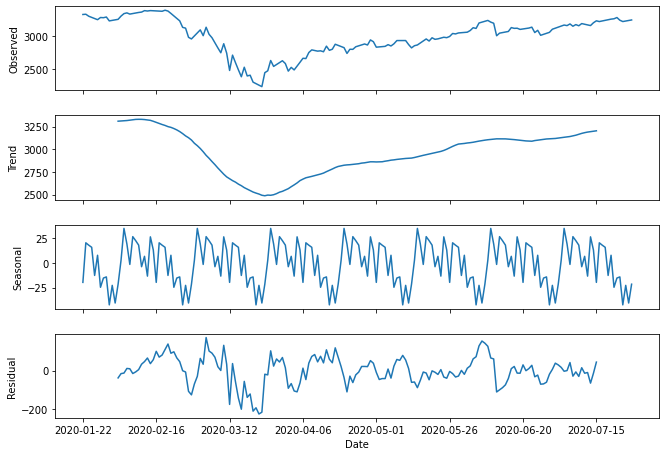

In [ ]:
result = seasonal_decompose(df_snp500['Adj_Close_SP500'], model='additive', freq=25)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 7)

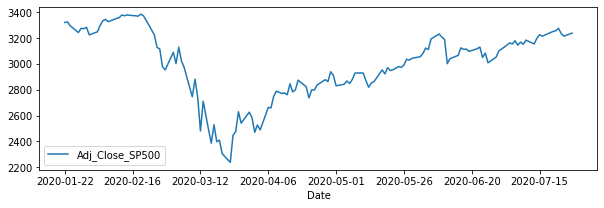

In [ ]:
df_snp500.plot(figsize=(10, 3))

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 25, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

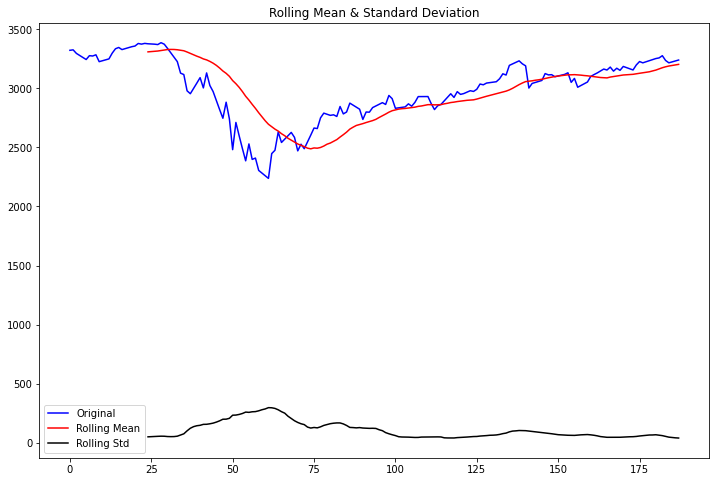

Results of Dickey-Fuller Test:
p-value = 0.4055. The series is likely non-stationary.
Test Statistic                  -1.750116
p-value                          0.405494
#Lags Used                      11.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
test_stationarity(df_snp500['Adj_Close_SP500'])

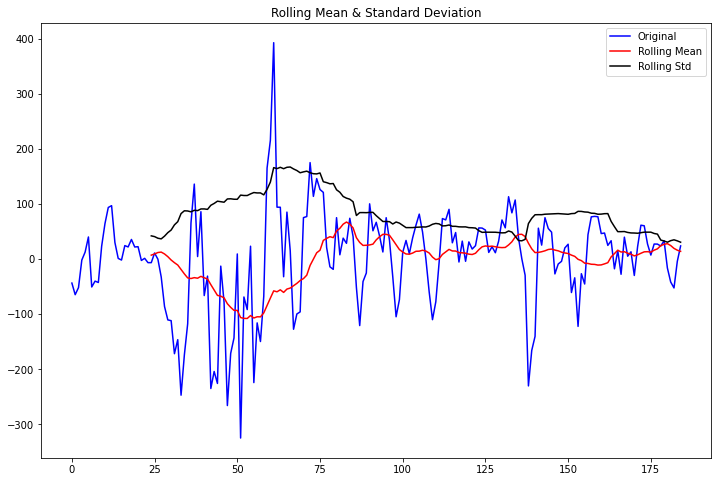

Results of Dickey-Fuller Test:
p-value = 0.0136. The series is likely non-stationary.
Test Statistic                  -3.329615
p-value                          0.013605
#Lags Used                       8.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
df_snp500['SP_Third_Difference'] = df_snp500['Adj_Close_SP500'] - df_snp500['Adj_Close_SP500'].shift(3)
test_stationarity(df_snp500['SP_Third_Difference'].dropna(), window = 25)

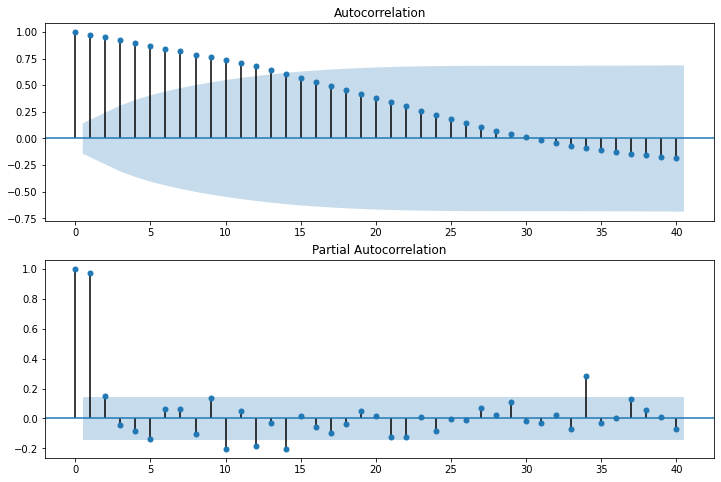

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_snp500['Adj_Close_SP500'], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_snp500['Adj_Close_SP500'], lags=40, ax=ax2)

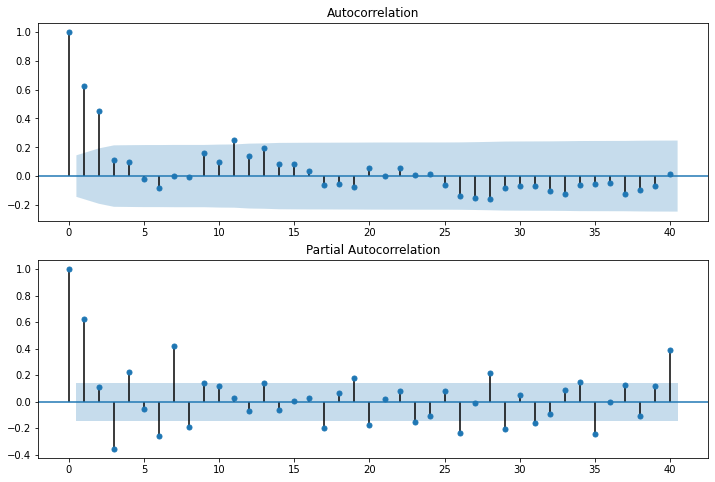

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_snp500['SP_Third_Difference'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_snp500['SP_Third_Difference'].dropna(), lags=40, ax=ax2)

In [ ]:
arima_mod6 = sm.tsa.ARIMA(df_snp500['Adj_Close_SP500'], (3,3,5)).fit(disp=False)
print(arima_mod6.summary())

ValueError: ignored

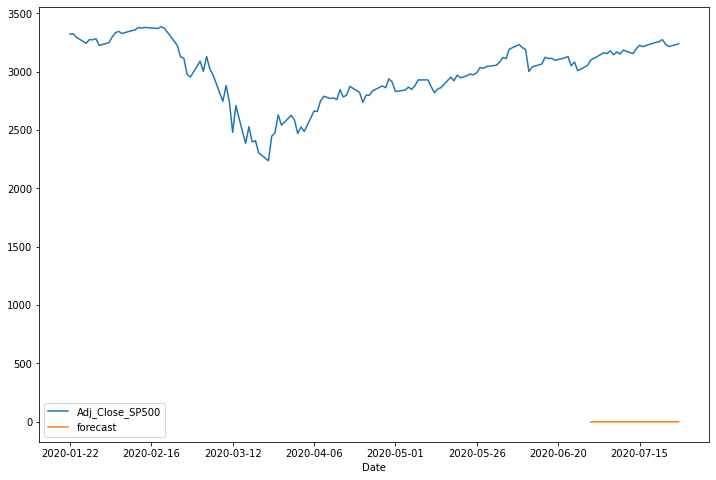

In [ ]:
# model = ARIMA(df_snp500['Adj_Close_SP500'], order=(2, 1, 2))  
# results_ARIMA = model.fit()  


df_snp500['forecast']=arima_mod6.predict(start=160,end=187,dynamic=True)
df_snp500[['Adj_Close_SP500','forecast']].plot(figsize=(12,8))


# plt.plot(df_snp500['SP_First_Difference'].values)
# plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

NormaltestResult(statistic=38.32574546093449, pvalue=4.760692336347452e-09)


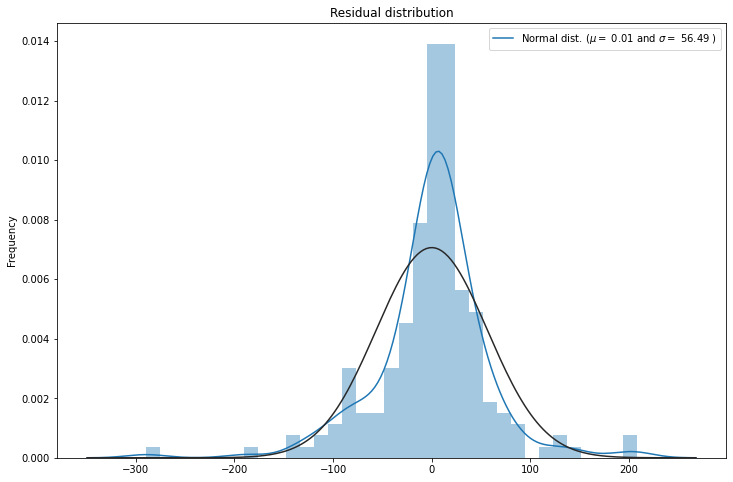

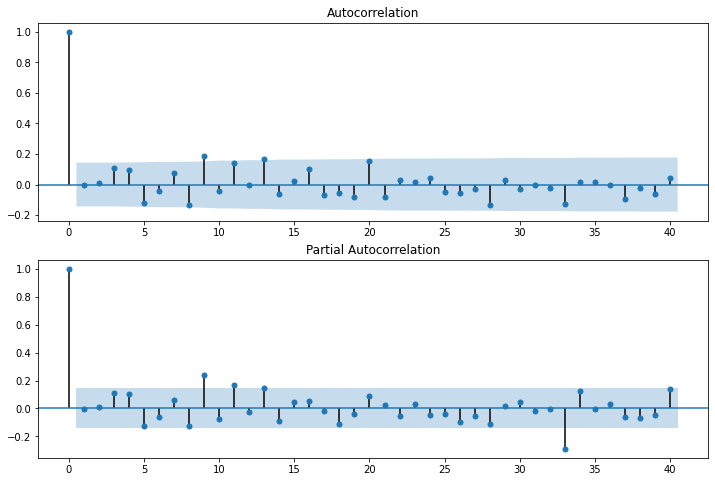

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [ ]:
# sarima_mod6 = sm.tsa.statespace.SARIMAX(df_snp500['Adj_Close_SP500'], trend='n', order=(2,1,2)).fit()
# print(sarima_mod6.summary())

sarimax_model=sm.tsa.statespace.SARIMAX(df_snp500['Adj_Close_SP500'],order=(2, 1, 1),seasonal_order=(2,1,1,32)).fit()
print(sarimax_model.summary())


                                 Statespace Model Results                                 
Dep. Variable:                    Adj_Close_SP500   No. Observations:                  188
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 32)   Log Likelihood                -872.544
Date:                            Thu, 19 Nov 2020   AIC                           1759.088
Time:                                    03:37:49   BIC                           1780.392
Sample:                                         0   HQIC                          1767.741
                                            - 188                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8326      0.081     10.222      0.000       0.673       0.992
ar.L2          0.1669      0.078   

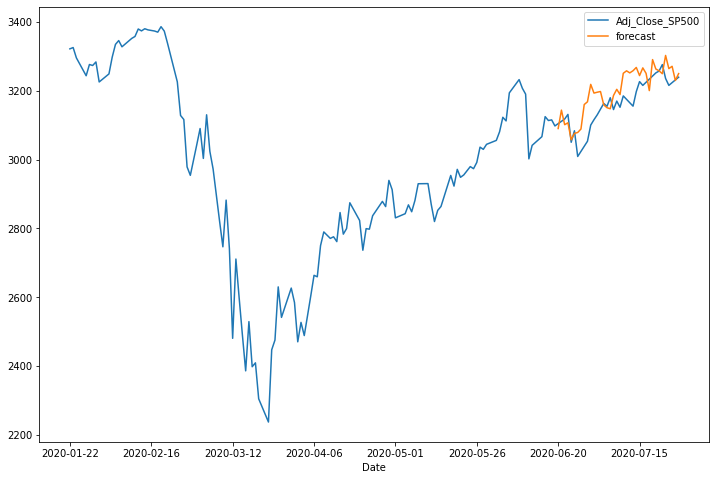

In [ ]:
df_snp500['forecast']=sarimax_model.predict(start=150,end=187,dynamic=True)
df_snp500[['Adj_Close_SP500','forecast']].plot(figsize=(12,8))

NormaltestResult(statistic=399.79875012929335, pvalue=1.5303982961934647e-87)


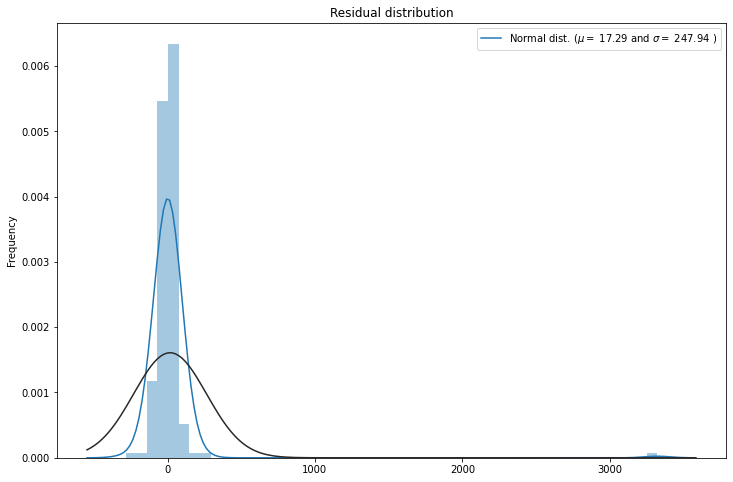

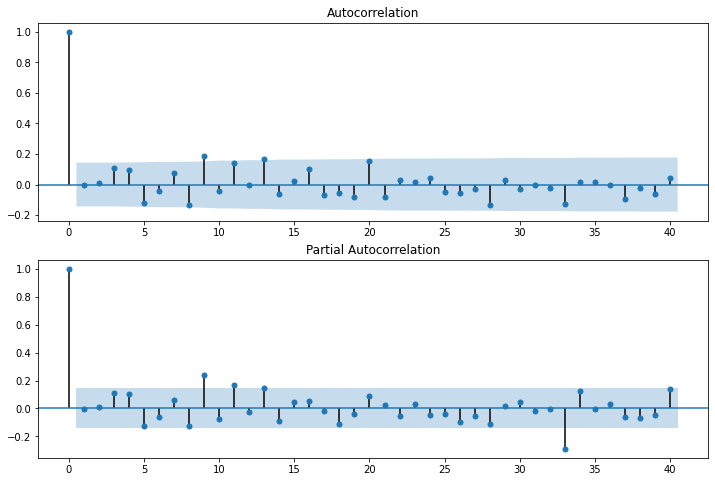

In [ ]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)